# Problem Set 10
## Fundamentals of Simulation Methods, WiSe 20/21
#### Author: Elias Olofsson
#### Date: 2021-02-06

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpltools import annotation

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

In [2]:
def finite_volume(N_list=[100], CFL=0.4):
    '''
    N_list :   Number of cells in domain (excluding ghost cells).
    CFL:  CFL-parameter.
    '''
    # Parameters
    cs    = 1     # Isothermal speed of sound.
    x_min = 0     # Left domain edge
    x_max = 1     # Right domain edge (x_min < x_max)
    T     = 1     # Integration time. 
    
    # Inital conditions
    A = 1e-6
    K = np.array([1, -1])

    #--------------------------------------------------------------------
     # List for L2 errors.
    L2 = []
    
    # For each resolution, perform the simulation.
    for N in N_list:  
    
        # Cell size.
        dx = (x_max - x_min)/N 

        # Position vector (Excluding ghost cells).
        x = np.linspace(x_min+dx/2, x_max-dx/2, N)

   
        # Pre-allocate state vector.
        q = np.zeros((2,N+2))

        # Set inital conditions.
        q[0,1:-1] = 1 + A*K[0]*np.sin(2*np.pi*x)
        q[1,1:-1] = A*K[1]*np.sin(2*np.pi*x)

        # Euler flux function.
        def F(q):
            return np.array([q[1], q[1]**2/q[0] + q[0]*cs**2])

        # HLL flux function. 
        def F_HLL(qL, qR, SL, SR):
            return (F(qL)*(SL>=0.) 
                    + F(qR)*(SR<=0.) 
                    + (SR*F(qL)-SL*F(qR)+SL*SR*(qR-qL))/(SR-SL) * ((SL<0.)&(SR>0.)))

        # Create output list.
        q_out = []

        # Main simulation loop.
        t = 0
        while t < T:
            # Store state vector in output.
            q_out.append(q[:,1:-1].copy())

            # Update timestep size.
            dt = CFL*dx/(np.max(np.abs(q[1,1:-1]/q[0,1:-1])) + cs)

            # Apply periodic boundary conditions.
            q[:,0]  = q[:,-2]
            q[:,-1] = q[:,1]

            # At all interfaces, get left and right states (constant recontruction).
            qL = q[:,:-1]  # len = N+1
            qR = q[:,1:]

            # Get wave speed estimates at cell interfaces.
            uLR = np.array([qL[1]/qL[0], qR[1]/qR[0]])
            SL = np.min(uLR, axis=0) - cs
            SR = np.max(uLR, axis=0) + cs

            # Determine fluxes at interfaces.
            Flux = F_HLL(qL, qR, SL, SR)

            # Get residuals
            R = dt/dx * (Flux[:,1:]-Flux[:,:-1]) 

            # Update solutionin time (RK1)
            q[:,1:-1] -= R

            # Update time.
            t += dt

        # Convert list to array.
        q  = np.array(q_out) 

        if len(N_list) < 2:  
            # Propagation of density in time.
            plt.figure(figsize=(6,6))
            plt.imshow(q[:,0])
            plt.show()

            # Plotting density at start and finish 
            plt.plot(x, q[0,0])
            plt.plot(x, q[-1,0])
            plt.show()

        # Calculate L1 norm of final state, compared to inital state.
        L1 = np.sum(np.abs(q[0]-q[-1]), axis=1)/N
        L2.append(np.sum(L1**2)**0.5)
        
    return L2        

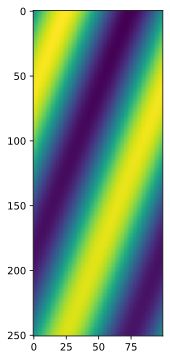

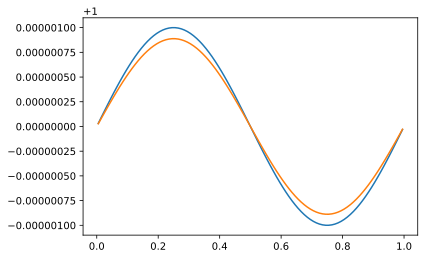

L1 error = [1.0058726759695919e-07]


In [3]:
L1 = finite_volume()
print(f'L1 error = {L1}')

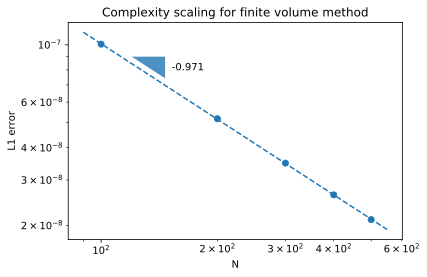

In [4]:
# Simulate for different resolutions.
N_list=[100,200,300,400,500]
L1 = finite_volume(N_list)

# Slope indicator pos.
pos = (120, 0.9e-7)

# Linear regression in loglog
N_lin = np.linspace(N_list[0]*0.9, N_list[-1]*1.1)
coef = np.polyfit(np.log(N_list), np.log(L1), 1)
plt.loglog(N_lin, N_lin**coef[0]*np.exp(coef[1]),'--')
annotation.slope_marker(pos, np.around(coef[0], 3), 
                        poly_kwargs={'facecolor': 'tab:blue', 'alpha': 0.8})

# Plot data points
plt.loglog(N_list, L1, 'o', color='tab:blue')

# Plot settings
plt.xlabel('N')
plt.ylabel('L1 error')
plt.title('Complexity scaling for finite volume method')
plt.show()